In [2]:
pip install ppscore

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for ppscore: filename=ppscore-1.2.0-py2.py3-none-any.whl size=13050 sha256=4f484a5c351861d722826b504383d268a52477c095bf5d7737736f023a21b16d
  Stored in directory: /root/.cache/pip/wheels/50/cc/8f/d0da07e4ec4e7a4c4cf32aee9057e4d1c318de910543b4684e
Successfully built ppscore


In [3]:
import ppscore as pps
import pandas as pd

# Preparación de datos
##Carga y exploración básica


Los features del dataset son:
* **satisfaction_level**: Nivel de Satisfacción, de 0 a 1 (Flotante).
* **last_evaluationTime**: Años desde la última evaluación de desempeño (Flotante)
* **number_project**:Cantidad de proyectos terminados durante la vinculación laboral (Entera)
* **average_montly_hours**: Horas promedio mensuales trabajadas (Entera)
* **time_spend_company**: Años de vinculación en la compañía (Entera)
* **Work_accident**: Si el empleado tuvo o no Accidente de trabajo (Binaria)
* **left**: Si el empleado dejo o no el trabajo (Variable Respuesta) (Binaria)
* **promotion_last_5years**: Si el empleado tuvo o no un ascenso en los últimos 5 años (Binaria).
* **sales**: Departamento al que el empleado estuvo vinculado (Categórica).
* **salary**: Nivel relativo del salario (low, medium, high) (Categórica)



Se cargan los datos y se validan ciertos elementos, a saber:

*   Que no haya datos faltantes 
*   Que todos los datos sean coherentes con las variables
*   Que la variable respuesta este balanceada 

Después de estas validaciones iniciales, se modifican los nombres de las variables para su interpretabilidad y se realiza un Análisis de Datos Exploratorio para conocer mejor el dataset.


In [7]:
#Se carga y presentan los datos
df=pd.read_csv("HR_comma_sep.csv")
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [18]:
#Verificación de datos nulos en el dataset
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [24]:
#Para variables categoricas y binarias, verificación de que no hayan elementos mal escritos o similar.
#Para esto, se imprimen los valores únicos de cada variable
variables_bin_cat=[ 'Work_accident', "left", "promotion_last_5years", "sales", "salary"]
[ (i, df[i].unique()) for i in variables_bin_cat]

[('Work_accident', array([0, 1])),
 ('left', array([1, 0])),
 ('promotion_last_5years', array([0, 1])),
 ('sales',
  array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
         'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)),
 ('salary', array(['low', 'medium', 'high'], dtype=object))]

In [8]:
#Para la verificación de variables númericas continuas, se usa DataFrame.describe() para validar el rango de los datos
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


De este dataframe se puede observar que:
1.   Las evaluaciones de desempeño se realizan juiciosamente de manera anual, dado que el máximo valor es 1 (eso, o quizá son más bien el nivel de desempeño en la última evaluación de desempeño)
2.   Existen empleados que trabajan más de 10 horas al día en promedio (máximo de 310 horas al mes/30 días al mes= 10.33 horas al día). A priori, parece una posible causa de abandono.
3. Se observa que la mayoría de empleados (al menos el 75%) no han abandonado a la compañía, recibido un ascenso en los últimos 5 años o tenido un accidente de trabajo. Esto sugiere que el dataset está no balanceado
4. Igualmente, al menos el 75% de los empleados a trabajado con la compañía menos de 5 años, por lo que el punto 3 parece indicar que no hay muchos ascensos en la companía (otro posible factor de abandono)
5. En general, parece no existir problemas con los datos.




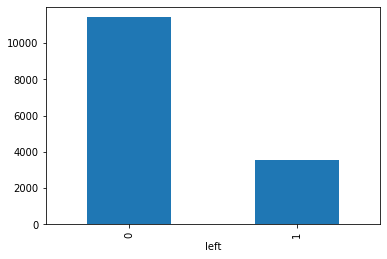

In [28]:
#Se verifica si la variable respuesta se encuentra balanceada en el dataset, mostrando el conteo de la misma
df.groupby("left")['sales'].count().plot(kind='bar')

In [34]:
#Se renombra "sales" como "department", "salary" como "salary_level", "left" como "employee_left"
#Esto es para dar nombres más interpretables de las variables
df=df.rename(columns = {'sales':'department', 'salary': 'salary_level', 'left':'employee_left'})



# Análisis Exploratorio de Datos (EDA)

Se revisará a mayor profundidad los datos para detectar ciertas interacciones y guiar la futura interpretación de los modelos.

Para ello, se revisarán interacciones, agrupaciones y visualizaciones de los datos, y se generarán ideas del algunas interacciones interesantes que se detecten. 

1. Observar si, al agrupar los datos por alguna variable, se observa que alguna otra tiene un nivel diferente (por ejemplo, si se ve un cambio en los niveles de motivación entre los diferentes niveles de salario).
2. Generar algunos heatmaps para apoyar las posibles tendencias que se vean (por ejemplo, detectar los departamentos de mayor rotación de personal)
3. Generar visualizaciones de apoyo para encaminar el primer modelo (elegir features)



In [42]:
df.groupby('employee_left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
employee_left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


In [48]:
df.groupby(['employee_left','salary_level']).mean()

satisfaction_level  ...  promotion_last_5years
employee_left salary_level                      ...                       
0             high                    0.651879  ...               0.062338
              low                     0.668103  ...               0.010109
              medium                  0.668875  ...               0.034315
1             high                    0.434512  ...               0.000000
              low                     0.441248  ...               0.006446
              medium                  0.438550  ...               0.003797

[6 rows x 7 columns]

Se observa que el nivel de satisfacción es mayor para los empleados que se mantienen en la empresa. Los que aun trabajan han tenido más ascensos y accidentes de trabajo.

Los empleados de alto salario que abandonaron la empresa no tuvieron accidentes laborales o ascensos, siendo quizá este último una causa de su deserción.

In [43]:
df.groupby('salary_level').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,employee_left,promotion_last_5years
salary_level,,,,,,,,
high,0.637470,0.704325,3.767179,199.867421,3.692805,0.155214,0.066289,0.058205
low,0.600753,0.717017,3.799891,200.996583,3.438218,0.142154,0.296884,0.009021
medium,0.621817,0.717322,3.813528,201.338349,3.529010,0.145361,0.204313,0.028079


Se observa que el mayor salario parece inducir a menos probablidad de ascensos y a una menor tasa de abandono. Los demas factores lucen relativamente similares.

In [44]:
df.groupby('department').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,employee_left,promotion_last_5years
department,,,,,,,,
IT,0.618142,0.716830,3.816626,202.215974,3.468623,0.133659,0.222494,0.002445
RandD,0.619822,0.712122,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307
accounting,0.582151,0.717718,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253
hr,0.598809,0.708850,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298
management,0.621349,0.724000,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524
marketing,0.618601,0.715886,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117
product_mng,0.619634,0.714756,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000
sales,0.614447,0.709717,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155
support,0.618300,0.723109,3.803948,200.758188,3.393001,0.154778,0.248991,0.008973


Parece ser que el departamento en que un empleado trabaja afecta principalmente sus posibilidades de ascenso. La tasa de salida varía por deparamento también, pero en una menor medida comparado con el ascenso en los últimos 5 años.


In [45]:
df.groupby('number_project').mean()

,satisfaction_level,last_evaluation,average_montly_hours,time_spend_company,Work_accident,employee_left,promotion_last_5years
number_project,,,,,,,
2,0.478769,0.568505,160.342546,3.180486,0.092965,0.656198,0.015494
3,0.687670,0.716572,197.507522,3.286560,0.175092,0.017756,0.023428
4,0.695132,0.740009,205.122108,3.454983,0.156472,0.093700,0.026804
5,0.678888,0.762010,212.061572,3.800072,0.150670,0.221659,0.018109
6,0.273458,0.786550,238.694208,4.192504,0.114140,0.557922,0.017036
7,0.118711,0.859609,276.078125,4.113281,0.015625,1.000000,0.000000


Podría decirse que los proyectos ejecutados podrían mostrar la responsabilidad asignada en la organización. Debe haber un equilibrio: Ni tan poca responsabilidad que parezca que la organización no confía en el empleado, ni tanta que parezca que el empleado es un solo departamento.

Es interesante que aquellos empleados con el mínimo y máximo número de proyectos asignados son los empleados más propensos a abandonar la organización.

Igualmente, los empleados con el mayor número de proyectos realizados no han tenido un ascenso en los últimos 5 años. "Mucha carga, poca recomensa" puede ser un motivo de abandono en esta organización.

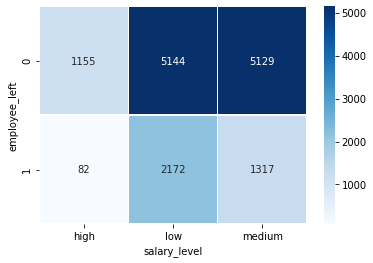

In [93]:
def heatmap_2_vars_count(df, var1, var2):
  ##################################################
  ### ENTRADAS ###
  # df: DataFrame
  # var1: Un feature del dataframe
  # var2: Un feature del dataframe
  ### SALIDAS ###
  #sns.heatmap(...): Un mapa de calor en seaborn del cruce de agrupación por COUNT() 
  # de las variablesvar1 y var2 del dataframe df.
  ###################################################

  heat_df=[]
  heat_df=pd.DataFrame(df.groupby([var1,var2]).count().iloc[:,1]).reset_index()
  cols=heat_df.columns
  value=[y for y in cols if y not in [var1, var2]]
  heat_df=heat_df.pivot(columns=var1, index=var2, values=value[0])
  return sns.heatmap(heat_df, cmap="Blues",linewidths=0.5, annot=True, fmt='g')

  
heatmap_2_vars_count(df, "salary_level", "employee_left")

Se observa que el alto salario parece "prevenir" el abandono en la empresa, dado que al incrementar el nivel de salario, existe un menor porcentaje de personas que abandonan la empresa.

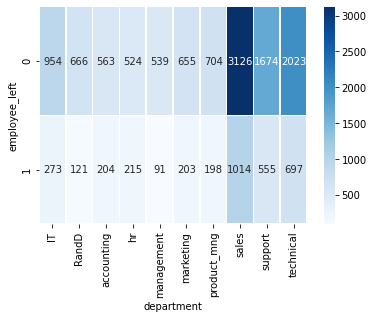

In [94]:
heatmap_2_vars_count(df, "department", "employee_left")

Se logra ver que los deparamentos de Sales, support y techinical poseen mayor munero de empleados. Además, se ve que existen departamentos como management que tienen una menor tasa de salida (salen 91 de 539+91, vs digamos, en sales que salen 1014 de 1014+3126- que es casi un tercio-)

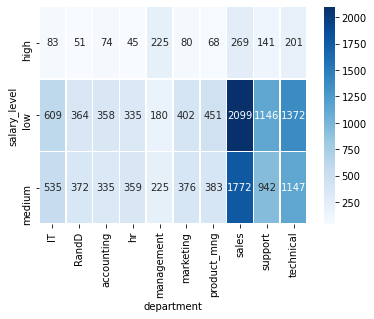

In [96]:
heatmap_2_vars_count(df, "department", "salary_level")

Los niveles de salario Low y Medium tienen un comportamiento similar entre los departamentos.  Los departamentos Sales, technical y Management son departamentos que presentan un número relativamente mayor de personas de mayor salario.

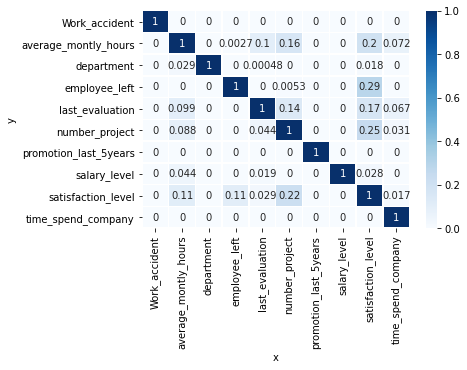

In [35]:
#Se realiza un mapa de calor de Predictive Power Score (PPS).
#El PPS es una métrica que mide el poder predictivo de una variable sobre otra.
#Esta se utiliza para observar correlaciones y posibles variables de interés para los modelos
import seaborn as sns
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)

El Predictive Power Score es una medida del poder predictivo de una variable. 

Esta gráfica nos muestra que la variable "employee_left" puede ser predecia por las variables "number_projects", y "satisfaction_level", pues la fila de "employee_left" posee valores en estas columnas.

Esta gráfica parece apoyar algunas de las hipótesis que se han ido formando:
1. El número de proyectos si tiene poder predictivo sobre la satisfacción del empleado.
2. La variable que mayor poder predictivo tiene es la satisfacción del empleado.

# Modelado
## Preparación de los datos
Se aplica cambios a los datos originales, haciendo las variables departmetn y salary_level categóricas.

Se probarán inicialmente los modelos:

* Regresión Logística
* Random Forest (Clasificador)
* Support Vector Machine (Clasificador)
* KNN (Clasificador)

Para las pruebas iniciales, se hará un split 80-20 para Entrenamiento y Prueba, se tomarán más muestras de la clase minoritaria (upsampling) para manejar la clase no balanceada y se tomará la versión "por defecto" de los modelos en sklearn con todos los features del set de datos. Se presentará la precisión en el set de prueba y la matriz de confusión. El objetivo de este paso es la generación de un insight inicial de que tan buenos predictores para el set de datos son cada uno de los modelos.

Posteriormente, se hará un tuneo de los hyper parámetros de cada modelo. En este paso, se compará la mejor versión encontrada de cada modelo entre si, y se elegirá aquel que posea una mejor ROC-AUC y Matriz de confusión, a partir de una 15-fold cross-validation.



In [101]:
df=df.astype({"department":"category", "salary_level":"category"})
df.dtypes

satisfaction_level        float64
last_evaluation           float64
number_project              int64
average_montly_hours        int64
time_spend_company          int64
Work_accident               int64
employee_left               int64
promotion_last_5years       int64
department               category
salary_level             category
dtype: object

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [288]:
def apply_model_to_df(df, method, method_name, x_cols):
  y=["employee_left"]
  X=x_cols
  y=df[y].copy().values.flatten()
  X=df[X].copy()
  X=pd.get_dummies(X).values
  
  if method==LogisticRegression():
    X["Intercept"]=0
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=1324)
  X_train_temp, y_train_temp = resample(X_train[y_train == 1],
                                  y_train[y_train == 1],
                                  replace=True,
                                  n_samples=X_train[y_train == 0].shape[0],
                                  random_state=666)
  X_train = np.concatenate((X_train[y_train == 0], X_train_temp))
  y_train = np.concatenate((y_train[y_train == 0], y_train_temp))
  model=method
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  cm = metrics.confusion_matrix(y_test, y_pred)
  print(method_name, " confusion Matrix:")
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
  print("Accuraccy: ", accuracy_score(y_test, model.predict(X_test)))

X_columns=[col for col in df.columns if col not in ["employee_left"]]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression  confusion Matrix:
Accuraccy:  0.7516666666666667


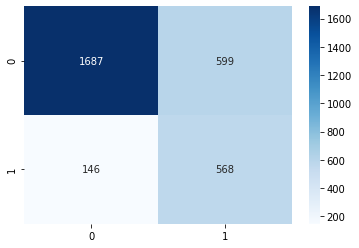

In [289]:
apply_model_to_df(df,LogisticRegression(), "Logistic Regression", X_columns)

Random Forest  confusion Matrix:
Accuraccy:  0.99


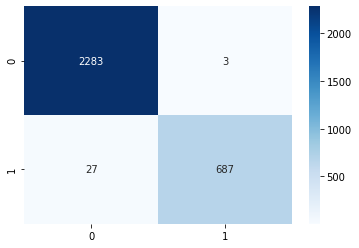

In [291]:
apply_model_to_df(df,RandomForestClassifier(), "Random Forest", X_columns)


Support Vector Machine Classifier  confusion Matrix:
Accuraccy:  0.6936666666666667


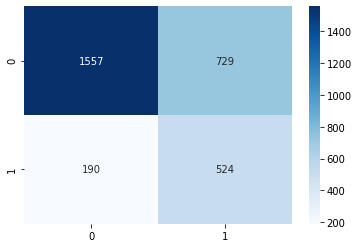

In [290]:
apply_model_to_df(df,SVC(), "Support Vector Machine Classifier",X_columns)


KNN  confusion Matrix:
Accuraccy:  0.9163333333333333


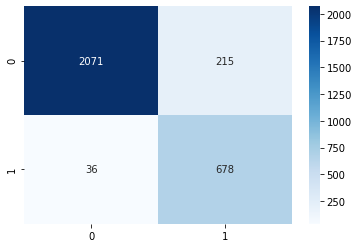

In [292]:
apply_model_to_df(df,KNeighborsClassifier(), "KNN", X_columns)
